In [121]:
import os
import logging
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.dummy import DummyClassifier
import tensorflow as tf

## Visualising Some Ring Predictions 

Not an important notebook, but I'll leave it here as I used it to make the most/least likely rings figure on the documentation.

Might need re-running to check the latest zoobot finetune_minimal.py works.

In [122]:
pred_loc = '/Users/walml/repos/zoobot/data/results/dr5_rings_cleaned_concat.parquet'  # reformatted already

df = pd.read_parquet(pred_loc)

In [123]:
print(len(df))

20000


In [124]:
df.columns.values

array(['image_loc', 'ring_pred', 'id_str'], dtype=object)

In [125]:
# df = df.rename(columns={'ring': 'ring_pred'})

In [126]:
labels = pd.read_csv('/Users/walml/repos/zoobot/data/ring_catalog_with_morph.csv')

In [127]:
labels.columns.values

array(['iauname', 'tag_count', 'local_png_loc',
       'smooth-or-featured_featured-or-disk_fraction',
       'disk-edge-on_no_fraction', 'has-spiral-arms_no_fraction', 'ring'],
      dtype=object)

In [128]:
labels['local_png_loc'] = labels['local_png_loc'].str.replace('/media/walml/beta1', '/Volumes/beta')

In [129]:
labelled_df = pd.merge(df, labels, left_on='id_str', right_on='iauname', how='inner').reset_index()

In [130]:
labelled_df['ring'].value_counts(), '{:.2f}'.format(labelled_df['ring'].mean())

(0    18027
 1      719
 Name: ring, dtype: int64,
 '0.04')

<AxesSubplot:>

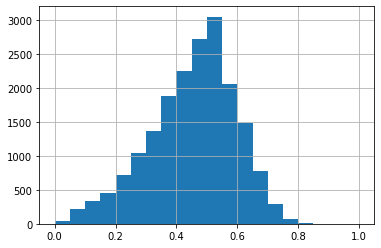

In [131]:
# df['ring_pred'].hist(range=(0, 1), bins=20)
labelled_df['ring_pred'].hist(range=(0, 1), bins=20)

<AxesSubplot:xlabel='ring', ylabel='ring_pred'>

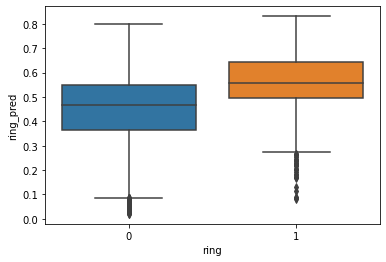

In [132]:
sns.boxplot(data=labelled_df, x='ring', y='ring_pred')

In [133]:
y_score = labelled_df['ring_pred'] 
y_true = labelled_df['ring']

confusion_matrix(y_pred=y_score > 0.6, y_true=y_true)  # likely biased as trained on artificially balanced data

array([[15670,  2357],
       [  440,   279]])

In [134]:
accuracy_score(y_pred=y_score > 0.6, y_true=y_true)

0.8507948362317295

In [135]:
accuracy_score(y_pred=np.zeros_like(y_true), y_true=y_true)

0.9616451509655393

In [136]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(np.zeros_like(labelled_df['ring']), labelled_df['ring'])

# dummy_clf.predict(np.random.rand(10))
dummy_preds = dummy_clf.predict(np.zeros_like(labelled_df))
accuracy_score(y_pred=dummy_preds, y_true=y_true)

0.9262242611757174

In [137]:
confusion_matrix(y_pred=dummy_preds, y_true=y_true) 

array([[17342,   685],
       [  698,    21]])

In [138]:
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)

In [139]:
len(fpr)

1373

In [141]:
dummy_clf.predict_proba(np.random.rand(10))

# dummy_clf.score(np.zeros_like(labelled_df['ring']), y)
# # 0.75

# dummy

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

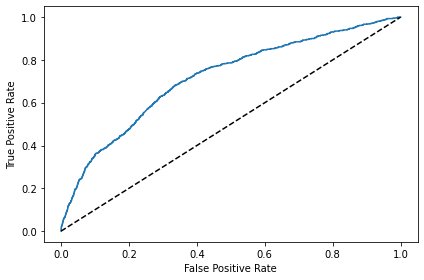

In [142]:
plt.plot(fpr, tpr)
plt.plot((0, 1), (0, 1), color='k', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()


In [153]:
def show_galaxies(df, start_index=0, crop_size=50):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(12, 5))
    all_axes = [ax for row in axes for ax in row]
    for n in range(10):
        galaxy = df.iloc[start_index+n]
        im = Image.open(galaxy['local_png_loc']).crop((50, 50, 424-crop_size, 424-crop_size))
        ax = all_axes[n]
        ax.imshow(im)
        ax.axis(False)
        ax.text(30, 30, 'R. Tags: {:.0f}'.format(galaxy['tag_count']), color='r')
        ax.text(30, 60, 'R. Pred: {:.2f}'.format(galaxy['ring_pred']), color='r')
#         ax.text(30, 90, 'Edge: {:.2f}'.format(1-galaxy['disk-edge-on_no_fraction']), color='r')
    fig.tight_layout()

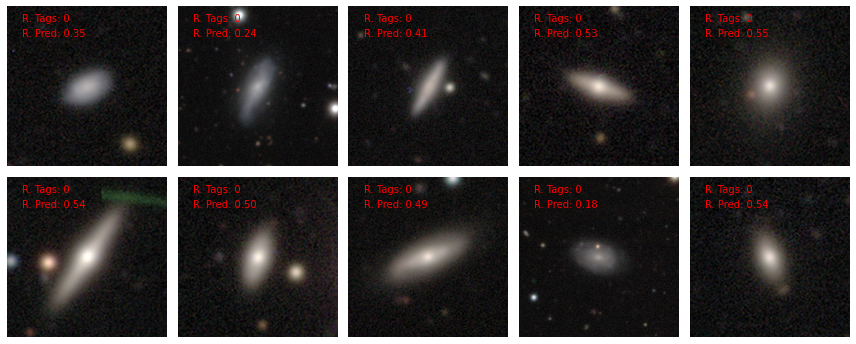

In [154]:
show_galaxies(labelled_df)

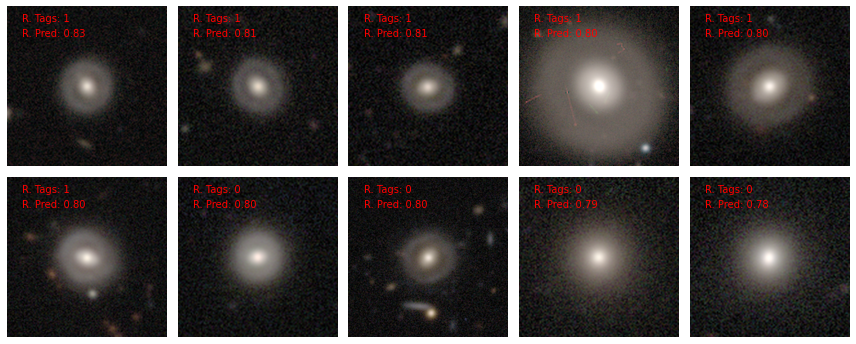

In [155]:
show_galaxies(labelled_df.sort_values('ring_pred', ascending=False))

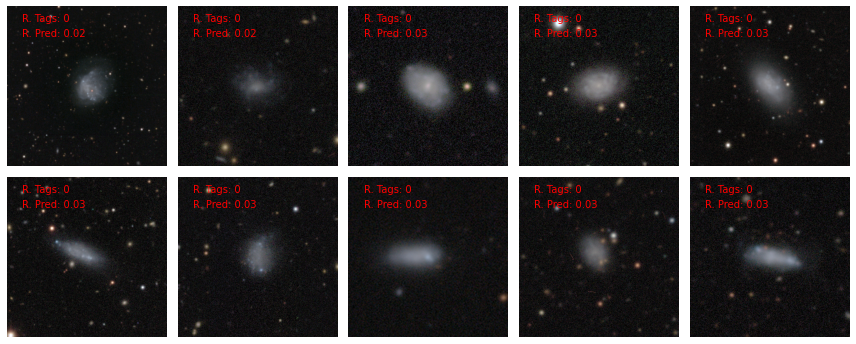

In [156]:
show_galaxies(labelled_df.sort_values('ring_pred'))

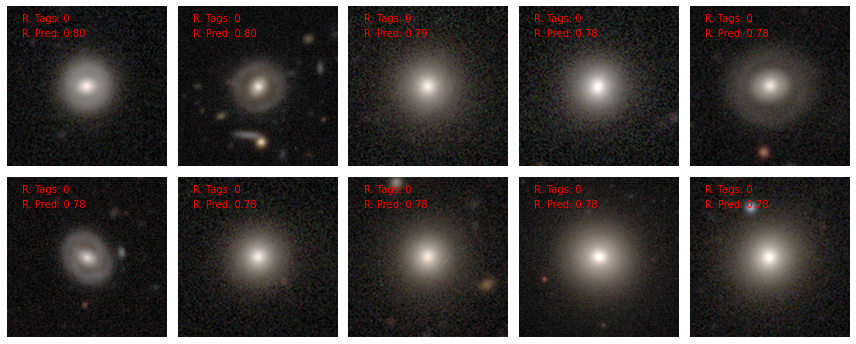

In [158]:
show_galaxies(labelled_df.query('ring == 0').sort_values('ring_pred', ascending=False))

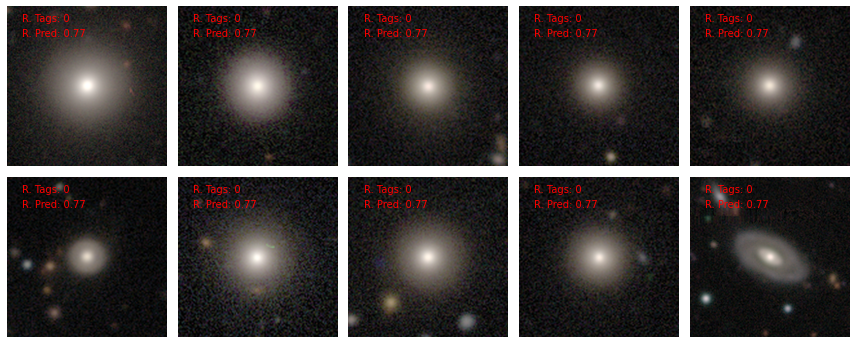

In [159]:
show_galaxies(labelled_df.query('ring == 0').sort_values('ring_pred', ascending=False)[10:])

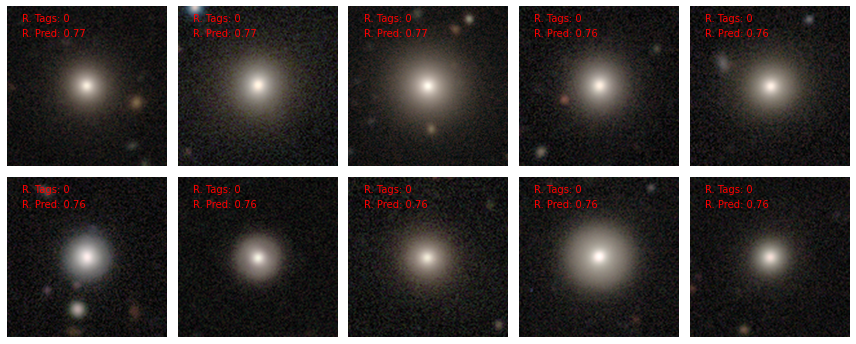

In [160]:
show_galaxies(labelled_df.query('ring == 0').sort_values('ring_pred', ascending=False)[20:])

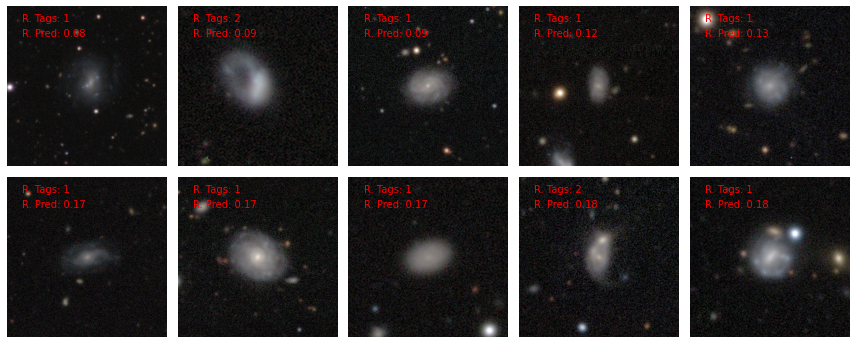

In [161]:
show_galaxies(labelled_df.query('ring == 1').sort_values('ring_pred', ascending=True))

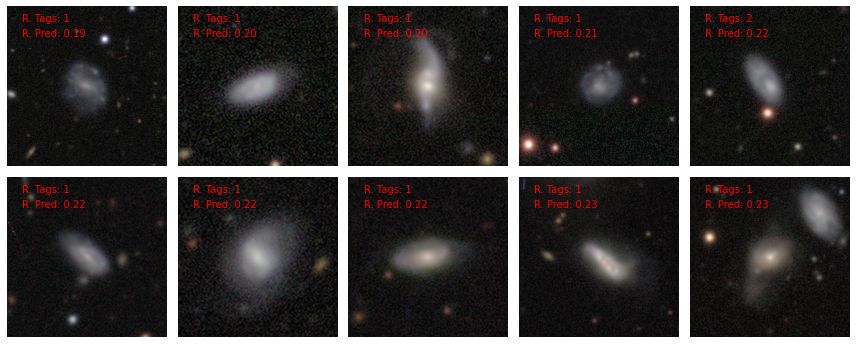

In [162]:
show_galaxies(labelled_df.query('ring == 1').sort_values('ring_pred', ascending=True)[10:])

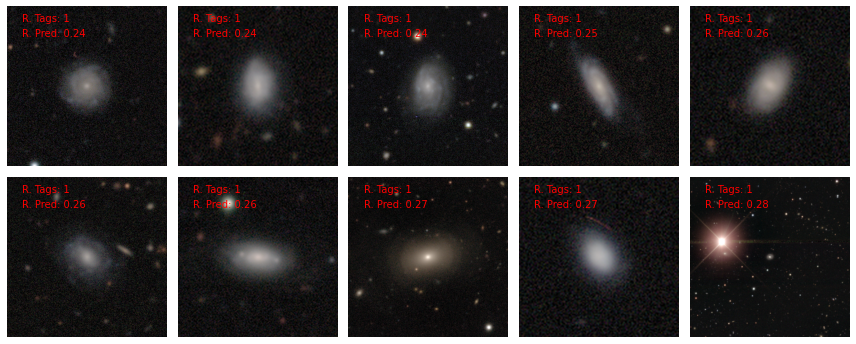

In [163]:
show_galaxies(labelled_df.query('ring == 1').sort_values('ring_pred', ascending=True)[20:])